## Raw ideas


so here's a few quick ideas for a validation schema:

- data shouldn't be shuffled before training, cause it's essential to have the time series values in consecutive order
- currently I came up with three ideas for a schema:

  1. `1,2train+3valid` -> `1,2,3train+4valid` -> `1,2,3,4train+5valid` etc.

     **Advatages**:

     - the train set grows, probably helping to test model's robustness
     - we always validate on different parts of the training set

     **Disadvantages**:

     - computationally heavy. at some point our train will contain almost the entire dataset

  2. `1,2train+3valid` -> `2,3train+4valid` -> `3,4train+5valid`

     **Advantages**:

     - fixed train size, no computational power issues
     - we can somewhat efficiently use our dataset since we use each fold several times during different trainig sessions

     **Disadvantages**:

     - the fact that different sets overlap might be a problem (shouldn't be, but who knows)

  3. `1,2train+3valid` -> `4,5train+6valid` -> `7,8train+9valid`

     **Advantages**:

     - the easiest one to implement, goes through each fold once only
     - it's guaranteed that there's no overlapping or data leaks

     **Disadvantages**:

     - data hugry in some sense, each fold is used only ones and each trainig session takes $f_{train} + 1$ folds, where $f_{train}$ is the amount of folds for the trainig set. this might be a problem assuming we have only 33 folds at maximum


model ideas:

- **decision tree-based algorithms (boosting, random forest)**:

  seems to be a good choice for the task since we have a lot of categorical features and the target is a discrete variable (which is typical for decision tree regression). at the same time, trees can be overfit easily, which can cause a huge loss in robustness and very inaccurate predictions on unseen data. ensembles will help to resolve this, but the problem of overfitting won't be gone completely. also, decision trees don't work well once something completely unseen shows up in input data, which might be a problem during future usage

- **auto-regressive models**:

  a time-series specific solution, that's supposed to do a good job at predicting future sales based on historical data. the main problems are the following: 1. I don't have any experience working with them (but we'll still try I guess) 2. the data is still quite noisy, so using AR models will require some additional preprocessing

- **RNNs**:

  one of the hardest models to implement, but at the same time a really powerfull (in theory) solution, that by definition fits the task idea quite well. RNNs can be really good when it comes to analyzing consecitive data (like text processing or time series)


useful additional features:

- day of the week
- month
- year
- lagged values (look them up in `EDA`)
- ...


## Loading and preparing the data

the point is to load the data in a format that's actually going to be fed to the model


In [1]:
from sys import path
path.append('../')


In [2]:
from src.utils import FoldLoader
from src.transform import ETL
from sklearn.ensemble import RandomForestRegressor
from tqdm.notebook import tqdm
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from matplotlib import pyplot as plt
import os
import xgboost
import seaborn as sns
import catboost as cb
import numpy as np
import pandas as pd
import re
from math import sin, cos, pi
from warnings import filterwarnings
filterwarnings('ignore', category=FutureWarning)



In [3]:
DATA_DIR = '../data/competitive-data-science-predict-future-sales/'

In [4]:
# TODO try to train model on ungrouped data
# the idea comes from the fact that the amount of samples in the test
# set (which is supposed to be one month long) is much greater
# than the amount of samples per month in grouped train

In [5]:
def etl_process():
    pipeline = ETL(DATA_DIR, ['sales_train.csv',
                   'items', 'shops', 'item_categories'])
    pipeline.extract()
    pipeline.tarnsform()
    pipeline.load(os.path.join(DATA_DIR, 'processed_files/'))

In [6]:
# uncomment if data reloading is needed (made this specifically after switching
# the working device since the data dir is not on github)
# etl_process()

In [7]:
data = pd.read_csv(os.path.join(
    DATA_DIR, 'processed_files/processed_data.csv'))
categories = pd.read_csv(os.path.join(DATA_DIR, 'item_categories.csv'))
items = pd.read_csv(os.path.join(DATA_DIR, 'items.csv'))

item_cats = items.merge(categories, how='inner', on='item_category_id')
test = pd.read_csv(os.path.join(DATA_DIR, 'test.csv'))
test['date_block_num'] = 34

In [8]:
# checked if maybe the higher amount of samples is due to the test
# set being a product of shops and items. it's not. 
shops = pd.read_csv(os.path.join(DATA_DIR, 'shops.csv'))
items = pd.read_csv(os.path.join(DATA_DIR, 'items.csv'))
print(shops.shape[0]*items.shape[0])
print(test.shape[0])

1330200
214200


In [9]:
columns_to_drop = ['date', 'item_name', 'shop_name']
data = data.drop(columns=columns_to_drop)

In [10]:
agg_cols = ['date_block_num', 'shop_id', 'item_id', 'item_category_name']

In [11]:
grouped = data.groupby(agg_cols, as_index=False).sum()
grouped_test = test.groupby(agg_cols[:-1], as_index=False).sum()

## Feature extraction


In [12]:
def extract_features(data: pd.DataFrame,
                     from_cols: list[str],
                     to_cols: list[str],
                     using: list[callable]):
    # TODO this probably needs to be documented since it's intended for further use
    # weird idea but should work
    # doesn't work for more complex features but we won't use those i suppose
    _data = data.copy()
    if not (len(from_cols) == len(to_cols) == len(using)):
        raise ValueError('list sizes have to match')
    for f, t, u in zip(from_cols, to_cols, using):
        _data[t] = _data[f].apply(u)
    return _data

In [13]:
new_features = [
    'month_sin',
    'month_cos',
    'item_cat',
    'general_cat'
]
sources = [
    'date_block_num',
    'date_block_num',
    'item_id',
    'item_id'
]

lookup = {}


def month_wrapper(func: callable):
    def ex_month(x):
        month = x % 12 + 1
        return func(2*pi*month/12)
    return ex_month


def fetch_cat(id):
    if id not in lookup:
        lookup[id] = item_cats[item_cats['item_id'] == id]\
            ['item_category_name'].unique()[0]
    return lookup[id]


def gen_cat(id):
    cat = fetch_cat(id)
    return 'Игры' if cat.startswith('Игры') \
        else re.split(r'\s*-\s*', cat)[0]


extractors = [
    month_wrapper(sin),
    month_wrapper(cos),
    fetch_cat,
    gen_cat
]

grouped = extract_features(grouped, sources, new_features, extractors)
grouped_test = extract_features(grouped_test, sources, new_features, extractors)

In [14]:
grouped.head(10)

,date_block_num,shop_id,item_id,item_category_name,item_price,item_cnt_day,item_category_id,month_sin,month_cos,item_cat,general_cat
0,0,2,27,Игры - PS3,2499.0,1,19,0.5,0.866025,Игры - PS3,Игры
1,0,2,33,Кино - Blu-Ray,499.0,1,37,0.5,0.866025,Кино - Blu-Ray,Кино
2,0,2,317,Книги - Аудиокниги 1С,299.0,1,45,0.5,0.866025,Книги - Аудиокниги 1С,Книги
3,0,2,438,Книги - Аудиокниги 1С,299.0,1,45,0.5,0.866025,Книги - Аудиокниги 1С,Книги
4,0,2,471,Книги - Методические материалы 1С,798.0,2,98,0.5,0.866025,Книги - Методические материалы 1С,Книги
5,0,2,481,Книги - Методические материалы 1С,330.0,1,49,0.5,0.866025,Книги - Методические материалы 1С,Книги
6,0,2,482,Программы - 1С:Предприятие 8,3300.0,1,73,0.5,0.866025,Программы - 1С:Предприятие 8,Программы
7,0,2,484,Программы - 1С:Предприятие 8,600.0,2,146,0.5,0.866025,Программы - 1С:Предприятие 8,Программы
8,0,2,491,Программы - 1С:Предприятие 8,600.0,1,73,0.5,0.866025,Программы - 1С:Предприятие 8,Программы
9,0,2,534,Программы - Обучающие,798.0,2,154,0.5,0.866025,Программы - Обучающие,Программы


## Catboost


In [15]:
in_features = ['shop_id', 'item_id', 'item_cat',
               'month_sin', 'month_cos', 'general_cat']
target = 'item_cnt_day'
cat_cols = ['shop_id', 'item_id', 'item_cat', 'general_cat']

In [10]:
def train_model(model, 
                train: pd.DataFrame, 
                cat_cols: list[str], 
                in_features: list[str], 
                target: str, 
                lower: int = 0, 
                upper: int = 33) -> list:
    # TODO needs to be documented too, but it's too early 
    mask_1 = train['date_block_num'] < upper
    mask_2 = train['date_block_num'] >= lower
    train_data = cb.Pool(train[mask_1 & mask_2][in_features],
                         train[mask_1 & mask_2][target],
                         cat_features=cat_cols)
    val_data = cb.Pool(train[train['date_block_num'] >= upper][in_features],
                       train[train['date_block_num'] >= upper][target],
                       cat_features=cat_cols)

    model.fit(train_data, eval_set=val_data, use_best_model=True,
              verbose=True, early_stopping_rounds=50)
    return model

In [17]:
model = cb.CatBoostRegressor(cat_features=cat_cols, random_seed=42)
catboost_model = train_model(model, 
    grouped, cat_cols, in_features, target, lower=0, upper=33)

Learning rate set to 0.161567
0:	learn: 3.6375565	test: 3.1245280	best: 3.1245280 (0)	total: 582ms	remaining: 9m 41s
1:	learn: 3.4700040	test: 2.9486609	best: 2.9486609 (1)	total: 930ms	remaining: 7m 44s
2:	learn: 3.3436464	test: 2.8166641	best: 2.8166641 (2)	total: 1.06s	remaining: 5m 54s
3:	learn: 3.2464819	test: 2.7364753	best: 2.7364753 (3)	total: 1.2s	remaining: 4m 59s
4:	learn: 3.1724607	test: 2.6864435	best: 2.6864435 (4)	total: 1.53s	remaining: 5m 4s
5:	learn: 3.1171678	test: 2.6706460	best: 2.6706460 (5)	total: 1.7s	remaining: 4m 41s
6:	learn: 3.0758721	test: 2.6582564	best: 2.6582564 (6)	total: 1.97s	remaining: 4m 40s
7:	learn: 3.0410740	test: 2.6595287	best: 2.6582564 (6)	total: 2.29s	remaining: 4m 44s
8:	learn: 3.0135502	test: 2.6678255	best: 2.6582564 (6)	total: 2.58s	remaining: 4m 44s
9:	learn: 2.9929568	test: 2.6718375	best: 2.6582564 (6)	total: 2.75s	remaining: 4m 32s
10:	learn: 2.9754055	test: 2.6794369	best: 2.6582564 (6)	total: 2.88s	remaining: 4m 19s
11:	learn: 2.95

In [18]:
def create_submission(model, test_df: pd.DataFrame,  in_features: list[str], filename: str, round=False):
    predicts = model.predict(test_df[in_features])
    if round:
        predicts = [int(x) for x in predicts]
    submission = pd.DataFrame(
        {'ID': range(len(predicts)), 'item_cnt_month': predicts})
    filename_ = os.path.join(DATA_DIR, filename)
    submission.to_csv(filename_, index=False)
    return predicts

In [19]:
predictions = create_submission(catboost_model, grouped_test, in_features, 'usual_subm.csv', round=True)

In [32]:
loader = FoldLoader(grouped, 12, n_valid_folds=2, folding_mode='stack')

In [40]:
template = 'fold: [{:2} out of {:2}]\tRMSE-train: [{:3.3f}]\tRMSE-val: [{:3.3f}]'
index = 1
history = {'loss': [], 'score': []}
loader.reset_folds()
model = cb.CatBoostRegressor(cat_features=cat_cols, random_seed=67)
for train, val in tqdm(loader):
    # fetch data
    train_data = cb.Pool(train[in_features],
                         train[target], cat_features=cat_cols)
    val_data = cb.Pool(val[in_features], val[target], cat_features=cat_cols)
    # reset the model
    model.fit(train_data, eval_set=val_data, use_best_model=True, verbose=False, early_stopping_rounds=50)

    # validate
    preds = model.predict(train[in_features])
    rmse_train = (np.sqrt(mean_squared_error(train[target], preds)))
    preds = model.predict(val[in_features])
    rmse_val = (np.sqrt(mean_squared_error(val[target], preds)))
    print(template.format(index, len(loader), rmse_train, rmse_val))
    index += 1
    

  0%|          | 0/21 [00:00<?, ?it/s]

fold: [ 1 out of 21]	RMSE-train: [2.937]	RMSE-val: [2.868]
fold: [ 2 out of 21]	RMSE-train: [3.431]	RMSE-val: [3.392]
fold: [ 3 out of 21]	RMSE-train: [2.842]	RMSE-val: [3.277]
fold: [ 4 out of 21]	RMSE-train: [3.050]	RMSE-val: [2.909]
fold: [ 5 out of 21]	RMSE-train: [2.999]	RMSE-val: [2.761]
fold: [ 6 out of 21]	RMSE-train: [2.978]	RMSE-val: [2.622]
fold: [ 7 out of 21]	RMSE-train: [2.945]	RMSE-val: [2.758]
fold: [ 8 out of 21]	RMSE-train: [2.880]	RMSE-val: [3.378]


In [ ]:
create_submission(model, test, in_features, 'stack_trained_subm.csv', round=True)

### CatBoost conclusion

So, the results are explainable, scores on validation and testing are approx. the same
The scores themselves aren't that good and I'm not sure what I can do about it.
Currently it seems like no matter what I do, the model starts overfitting after 
reaching the score of approx `2.65`, which doesn't seem that good

Right now the plan is to try different types of model and see if they will have
any similar issues

currenty the score situation is as follows:

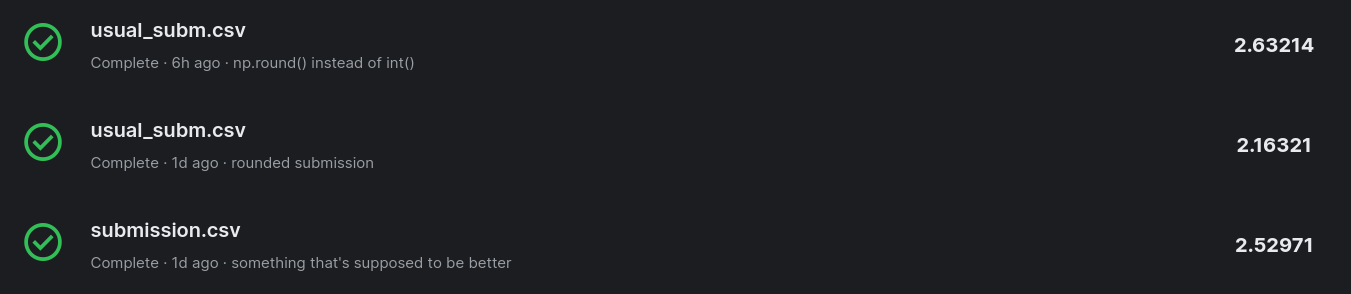

## XGBoost

## RandomForest

this one requires manually encoding some features, since it can't process categorical features out-of-the-box. again, planning to see the scores I get and compare to others


## RNN

requires encoding cat. features too.
